# Bayesian version of Andrew Tyre’s Does model averaging make sense?

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-darkgrid')
print('Runing on PyMC3 v{}'.format(pm.__version__))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Runing on PyMC3 v3.3


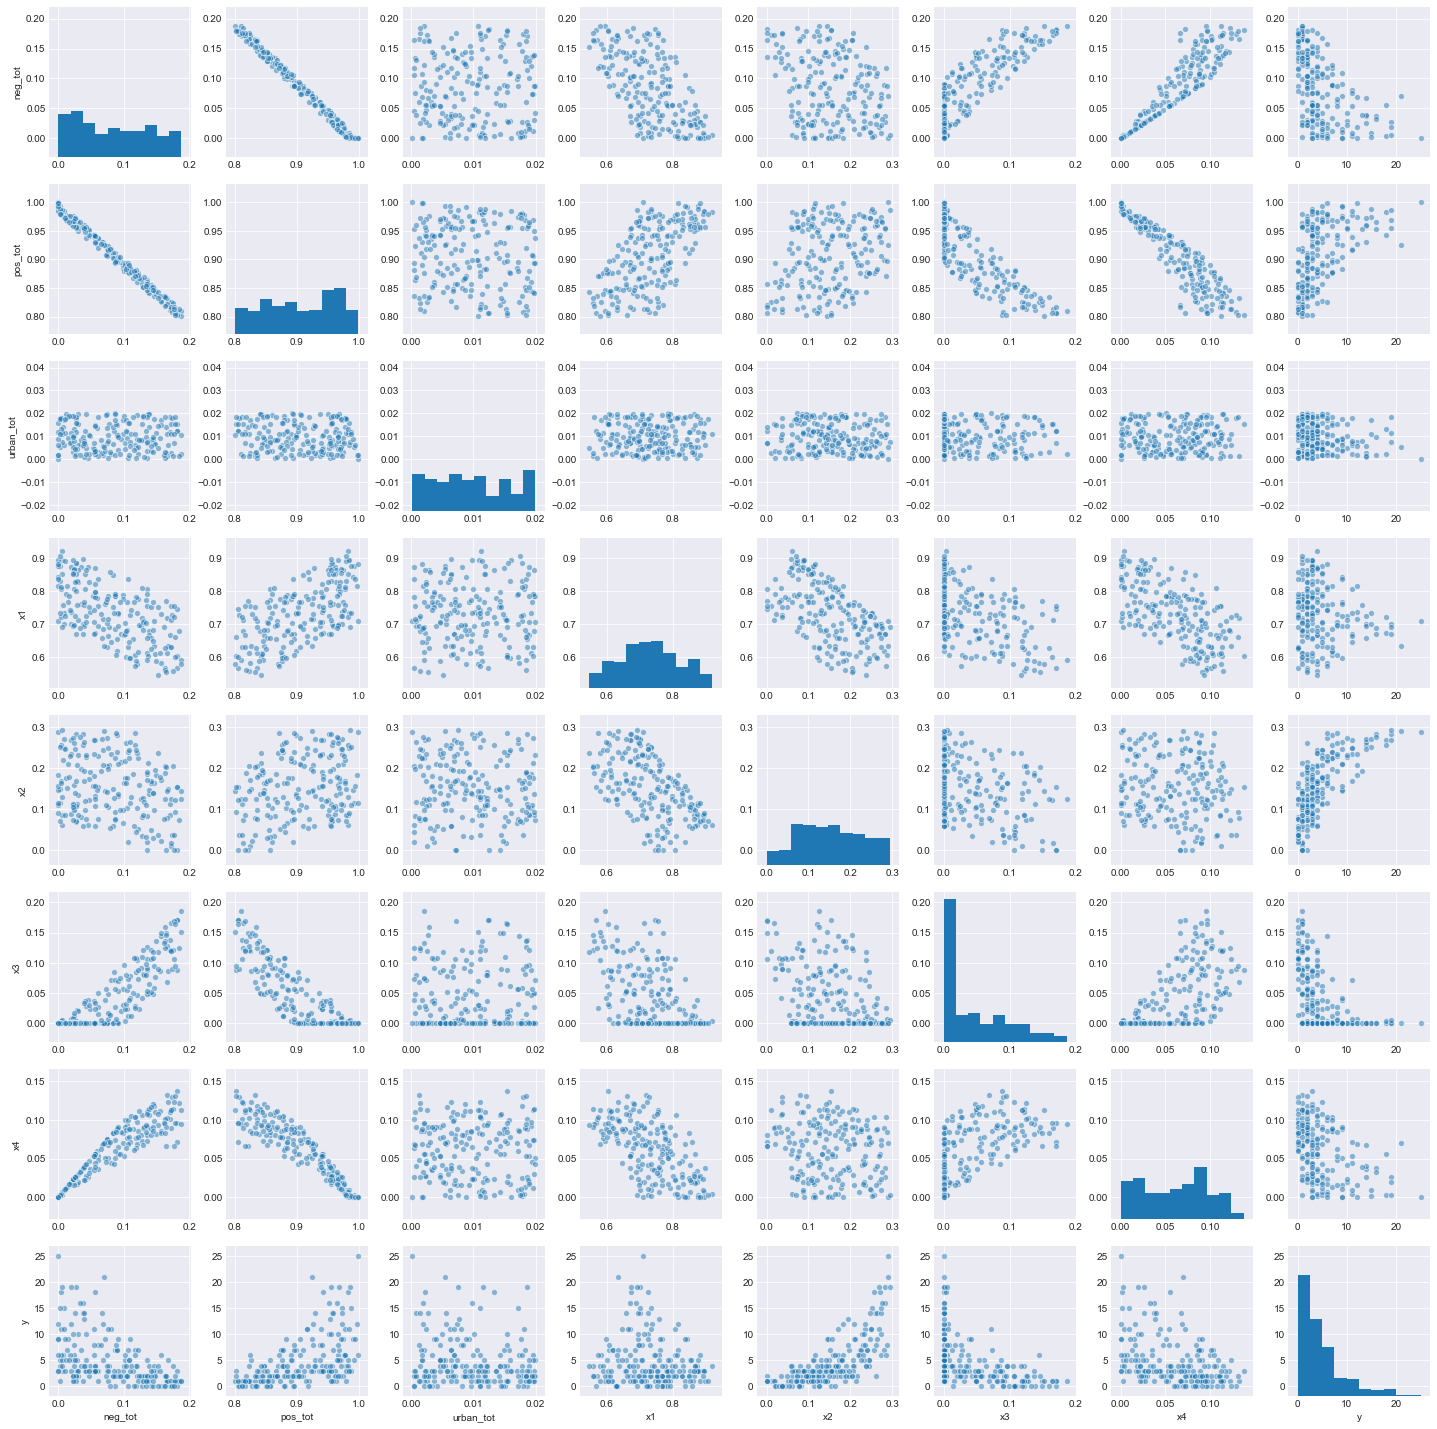

In [2]:
runif = np.random.uniform
pos_tot = runif(low=0.8, high=1.0, size=200)
urban_tot = np.min((runif(low=0., high=.02, size=200), 1.0 - pos_tot), axis=0)
neg_tot = 1.0 - np.min((pos_tot + urban_tot, np.ones(200)), axis=0)
x1 = np.max((pos_tot - runif(low=.05, high=.3, size=200), np.zeros(200)), axis=0)
x3 = np.max((neg_tot - runif(low=0., high=.1, size=200), np.zeros(200)), axis=0)
x2 = np.max((pos_tot - x1 - x3/2, np.zeros(200)), axis=0)
x4 = np.max((1 - x1 - x2 - x3 - urban_tot, np.zeros(200)), axis=0)
df = pd.DataFrame(
    dict(
        pos_tot=pos_tot,
        urban_tot=urban_tot,
        neg_tot=neg_tot,
        x1=x1, x2=x2, x3=x3, x4=x4
        )
    )
# true model and 200 Poisson observations
mean_y = np.exp(-5.8 + 6.3*df['x1'] + 15.2*df['x2'])
df['y'] = np.random.poisson(mean_y, size=200)

sns.pairplot(df, plot_kws={'alpha': .5});

In [3]:
scale = 2.5/np.std(df[['x1', 'x2', 'x3', 'x4']]).values

In [4]:
with pm.Model() as glmp:
    pm.glm.GLM.from_formula(
        'y ~ x1 + x2 + x3 + x4', data=df,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=10),
                    x1=pm.Normal.dist(mu=0, sd=scale[0]),
                    x2=pm.Normal.dist(mu=0, sd=scale[1]),
                    x3=pm.Normal.dist(mu=0, sd=scale[2]),
                    x4=pm.Normal.dist(mu=0, sd=scale[3])),
        family=pm.glm.families.Poisson()
              )
glmp

In [5]:
with glmp:
    trace0 = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log__, x4, x3, x2, x1, Intercept]
100%|██████████| 2000/2000 [04:33<00:00,  7.32it/s]
The acceptance probability does not match the target. It is 0.8850866824565929, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [6]:
pm.summary(trace0,
           varnames=['Intercept', 'x1', 'x2', 'x3', 'x4'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-12.973098,4.952809,0.208717,-22.298036,-2.999816,524.602710,1.004165
x1,13.577889,5.007919,0.210912,3.458805,22.971380,526.582217,1.004145
x2,22.251439,4.987195,0.209165,12.174057,31.753005,527.383929,1.004105
x3,8.581884,5.120797,0.213841,-1.526903,18.350199,542.440848,1.003710
x4,7.048345,5.106795,0.212402,-2.627485,17.122898,524.829827,1.004463


QR decomposition for the covariates. This part is not easy to do in glm module as we didnt implement a internal QR decomposition function.

In [34]:
import patsy
y, x = patsy.dmatrices('y ~ x1 + x2 + x3 + x4', df)
labels = x.design_info.column_names
X = np.asarray(x)[:, 1:]
Y = np.asarray(y)[:, -1]
q, r = np.linalg.qr(X)
Q = q*len(y)
R = r/len(y)
invR = np.linalg.inv(R)

In [35]:
with pm.Model() as glmp:
    b = pm.Normal('Intercept', mu=0., sd=10.)
    betas = pm.Normal('beta', mu=0., sd=2.5, shape=(4, 1))
    y_est = pm.math.exp(pm.math.dot(Q, betas)+b)
    y = pm.Poisson('y', mu=y_est.flatten(), observed=Y)

    mu_est = pm.math.dot(invR, betas)
    for i, il in enumerate(labels[1:]):
        pm.Deterministic(il, mu_est[i])
    trace0 = pm.sample(1000, tune=1000, cores=4, init=None)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, Intercept]


ImportError: [joblib] Attempting to do parallel computing without protecting your import on a system that does not support forking. To use parallel-computing in a script, you must protect your main loop using "if __name__ == '__main__'". Please see the joblib documentation on Parallel for more information

In [ ]:
pm.summary(trace0,
           varnames=['Intercept', 'x1', 'x2', 'x3', 'x4'])

In [ ]:
tracedf0 = pm.trace_to_dataframe(trace0,
                                 varnames=['x1', 'x2', 'x3', 'x4'])
sns.pairplot(tracedf0);